### Parameter Extraction for SLO-2 Ion Channel

In [1]:
"""
Example of using cwFitter to generate a HH model for SLO-2 ion channel
Based on experimental data from doi:10.1083/jcb.200203055
"""

import os.path
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../..')
from channelworm.fitter import *

In [2]:
userData = dict()

cwd=os.getcwd()

csv_path_VC_1 = os.path.dirname(cwd)+'/examples/slo-2-data/slo-2-VClamp/1.csv'
csv_path_VC_2 = os.path.dirname(cwd)+'/examples/slo-2-data/slo-2-VClamp/2.csv'
csv_path_VC_3 = os.path.dirname(cwd)+'/examples/slo-2-data/slo-2-VClamp/3.csv'
csv_path_VC_4 = os.path.dirname(cwd)+'/examples/slo-2-data/slo-2-VClamp/4.csv'
x_var_VC = {'type':'Time','unit':'ms','toSI':1e-3}
y_var_VC = {'type':'Current','unit':'nA','toSI':1e-9,'adjust':-0.82}
traces_VC = [{'vol':110e-3,'csv_path':csv_path_VC_1,'x_var':x_var_VC,'y_var':y_var_VC},
             {'vol':40e-3,'csv_path':csv_path_VC_2,'x_var':x_var_VC,'y_var':y_var_VC},
             {'vol':-140e-3,'csv_path':csv_path_VC_3,'x_var':x_var_VC,'y_var':y_var_VC},
             {'vol':-90e-3,'csv_path':csv_path_VC_4,'x_var':x_var_VC,'y_var':y_var_VC}]
ref_VC = {'fig':'6a','doi':'10.1038/77670'}
VClamp = {'ref':ref_VC,'traces':traces_VC}
# #
# csv_path_VC = os.path.dirname(cwd)+'/examples/slo-2-data/SLO-2-2000-VClamp.csv'
# x_var_VC = {'type':'Time','unit':'ms','toSI':1e-3}
# y_var_VC = {'type':'Current','unit':'nA','toSI':1e-9,'adjust':-0.82}
# traces_VC = [{'csv_path':csv_path_VC,'x_var':x_var_VC,'y_var':y_var_VC}]
# ref_VC = {'fig':'6a','doi':'10.1038/77670'}
# VClamp = {'ref':ref_VC,'traces':traces_VC}
#
csv_path = os.path.dirname(cwd)+'/examples/slo-2-data/SLO-2-2000-IV.csv'
ref = {'fig':'6a','doi':'10.1038/77670'}
x_var = {'type':'Voltage','unit':'mV','toSI':1e-3}
y_var = {'type':'Current','unit':'pA','toSI':1e-12}
IV = {'ref':ref,'csv_path':csv_path,'x_var':x_var,'y_var':y_var}

csv_path_POV = os.path.dirname(cwd)+'/examples/slo-2-data/SLO-2-2000-GV.csv'
ref_POV = {'fig':'6b','doi':'10.1038/77670'}
x_var_POV = {'type':'Voltage','unit':'mV','toSI':1e-3}
y_var_POV = {'type':'G/Gmax','unit':'','toSI':1}
POV = {'ref':ref_POV,'csv_path':csv_path_POV,'x_var':x_var_POV,'y_var':y_var_POV}

# userData['samples'] = {'IV':IV,'POV':POV}
userData['samples'] = {'VClamp':VClamp}
# userData['samples'] = {'IV':IV,'POV':POV,'VClamp':VClamp}

# args = {'weight':{'start':20,'peak':10,'tail':30,'end':30,4:50}}

In [4]:
myInitiator = initiators.Initiator(userData)
sampleData = myInitiator.get_sample_params()
bio_params = myInitiator.get_bio_params()
sim_params = myInitiator.get_sim_params()
myEvaluator = evaluators.Evaluator(sampleData,sim_params,bio_params)

In [5]:
# bio parameters for SLO-2
bio_params['cell_type'] = 'Xenopus oocytes'
bio_params['channel_type'] = 'SLO-2'
bio_params['ion_type'] = 'K'
bio_params['val_cell_params'][0] = 200e-9 # C_mem DOI: 10.1074/jbc.M605814200
bio_params['val_cell_params'][1] = 20e-6 # area DOI: 10.1101/pdb.top066308
bio_params['gate_params'] = {'vda': {'power': 1}}

bio_params['channel_params'] = ['g_dens','e_rev']
bio_params['unit_chan_params'] = ['S/m2','V']
bio_params['min_val_channel'] = [1e-4,-5e-3]
bio_params['max_val_channel'] = [10,   5e-3]

bio_params['channel_params'].extend(['v_half_a','k_a','T_a'])
bio_params['unit_chan_params'].extend(['V','V','s'])
bio_params['min_val_channel'].extend([-0.15, 0.001, 0.0001])
bio_params['max_val_channel'].extend([ 0.15,   0.1,  0.01])

# Simulation parameters for SLO-2 VClamp and I/V
sim_params['v_hold'] = -110e-3
sim_params['I_init'] = 0
sim_params['pc_type'] = 'VClamp'
sim_params['deltat'] = 1e-5
sim_params['duration'] = 0.059
sim_params['start_time'] = 0.0029
sim_params['end_time'] = 0.059
sim_params['protocol_start'] = -140e-3
sim_params['protocol_end'] = 110e-3
sim_params['protocol_steps'] = 10e-3

In [7]:
opt = '-pso'
# opt = '-ga'
# opt = None
if len(sys.argv) == 2:
    opt = sys.argv[1]

if ('IV' or 'POV') in sampleData and opt is not None:
    while True:
        q = raw_input("\n\nTry fitting curves (y,n):")
        if q == "n":
            break  # stops the loop
        elif q == "y":

            # Find initial guess for parameters using curve_fit, leastsq

            popt = None
            best_candidate = np.asarray(bio_params['min_val_channel']) + np.asarray(bio_params['max_val_channel']) / 2

            best_candidate_params = dict(zip(bio_params['channel_params'],best_candidate))
            cell_var = dict(zip(bio_params['cell_params'],bio_params['val_cell_params']))
            mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
            bestSim = mySimulator.patch_clamp()

            if 'IV' in sampleData:

                popt , p0 = mySimulator.optim_curve(params= bio_params['channel_params'],
                                                        best_candidate= best_candidate,
                                                        target= [sampleData['IV']['V'],sampleData['IV']['I']])

                print 'Params after IV minimization:'
                print p0
                IV_fit_cost = myEvaluator.iv_cost(popt)
                print 'IV cost:'
                print IV_fit_cost
                if 'POV' in sampleData:
                    POV_fit_cost = myEvaluator.pov_cost(popt)
                    print 'POV cost:'
                    print POV_fit_cost
                if 'VClamp' in sampleData:
                    VClamp_fit_cost = myEvaluator.vclamp_cost(popt)
                    print 'VClamp cost:'
                    print VClamp_fit_cost
                vData = np.arange(-0.140, 0.110, 0.001)
                Iopt = mySimulator.iv_act(vData,*popt)
                plt.plot([x*1e3 for x in bestSim['V_ss']],bestSim['I_ss'], label = 'Initial parameters', color='y')
                plt.plot([x*1e3 for x in sampleData['IV']['V']],sampleData['IV']['I'], '--ko', label = 'sample data')
                plt.plot([x*1e3 for x in vData],Iopt, color='r', label = 'Fitted to IV curve')
                plt.legend()
                plt.title("IV Curve Fit")
                plt.xlabel('V (mV)')
                plt.ylabel('I (A)')
                plt.show()

            elif 'POV' in sampleData:

                popt , p0 = mySimulator.optim_curve(params= bio_params['channel_params'],
                                                        best_candidate= best_candidate,
                                                        target= [sampleData['POV']['V'],sampleData['POV']['PO']],curve_type='POV')

                print 'Params after POV minimization:'
                print p0
                POV_fit_cost = myEvaluator.pov_cost(popt)
                print 'POV cost:'
                print POV_fit_cost
                if 'VClamp' in sampleData:
                    VClamp_fit_cost = myEvaluator.vclamp_cost(popt)
                    print 'VClamp cost:'
                    print VClamp_fit_cost
                vData = np.arange(-0.140, 0.110, 0.001)
                POopt = mySimulator.pov_act(vData,*popt)
                plt.plot([x*1e3 for x in bestSim['V_PO_ss']],bestSim['PO_ss'], label = 'Initial parameters', color='y')
                plt.plot([x*1e3 for x in sampleData['POV']['V']],sampleData['POV']['PO'], '--ko', label = 'sample data')
                plt.plot([x*1e3 for x in vData],POopt, color='r', label = 'Fitted to G/Gmax vs V curve')
                plt.legend()
                plt.title("G/Gmax vs V Curve Fit")
                plt.xlabel('V (mV)')
                plt.ylabel('G/Gmax')
                plt.show()

            if popt is not None:
                if opt == '-pso':
                    bio_params['min_val_channel'][0:4] = popt[0:4] - abs(popt[0:4]/2)
                    bio_params['max_val_channel'][0:4] = popt[0:4] + abs(popt[0:4]/2)
                else:
                    bio_params['min_val_channel'][0:4] = popt[0:4]
                    bio_params['max_val_channel'][0:4] = popt[0:4]

                best_candidate_params = dict(zip(bio_params['channel_params'],popt))
                cell_var = dict(zip(bio_params['cell_params'],bio_params['val_cell_params']))
                mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
                bestSim = mySimulator.patch_clamp()

                myModelator = modelators.Modelator(bio_params,sim_params)
                myModelator.compare_plots(sampleData,bestSim,show=True)
                myModelator.ss_plots(bestSim,show=True)

In [8]:
start = time.time()

if opt == '-ga':
    ga_args = myInitiator.get_opt_params()
    best_candidate, score = myEvaluator.ga_evaluate(min=bio_params['min_val_channel'],
                                                        max=bio_params['max_val_channel'],
                                                        args=ga_args)
elif opt == '-pso':
    pso_args = myInitiator.get_opt_params(type='PSO')
    pso_args['minstep'] = 1e-24
    pso_args['minfunc'] = 1e-24
    pso_args['swarmsize'] = 100
    pso_args['maxiter'] = 100
    best_candidate, score = myEvaluator.pso_evaluate(lb=bio_params['min_val_channel'],
                                                         ub=bio_params['max_val_channel'],
                                                         args=pso_args)
else:
    # best_candidate = [2.678373586024887e-08, -0.004343196320916513, -0.15148699378068883, 0.04457177073153084, 0.0006512657782666903]
    best_candidate = [2.6713432536911465e-08, -0.0043477407996737093, -0.077423632426596764, 0.030752484500400822, 0.0007076266889846564]
    best_candidate[0] = 2.6713432536911465e-08 / bio_params['val_cell_params'][1]

secs = time.time()-start
print("----------------------------------------------------\n\n"
          +"Ran in %f seconds (%f mins)\n"%(secs, secs/60.0))

best_candidate_params = dict(zip(bio_params['channel_params'],best_candidate))
cell_var = dict(zip(bio_params['cell_params'],bio_params['val_cell_params']))
mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
bestSim = mySimulator.patch_clamp()

myModelator = modelators.Modelator(bio_params,sim_params)
myModelator.compare_plots(sampleData,bestSim,show=True)
myModelator.ss_plots(bestSim,show=True)

print 'best candidate after optimization:'
print best_candidate_params

# Only for tau_max
if 'VClamp' in sampleData:
    for trace in sampleData['VClamp']['traces']:
        if 'vol' in trace:
            if trace['vol'] is None:
                pass
            elif trace['vol'] == 110e-3:
                end = sim_params['protocol_end']
                start = sim_params['protocol_start']
                sim_params['protocol_end'] = trace['vol']
                sim_params['protocol_start'] = trace['vol']

                x = np.asarray(trace['t'])
                on = sim_params['start_time']
                off = sim_params['end_time']
                onset = np.abs(x-on).argmin()
                offset = np.abs(x-off).argmin()
                t_sample_on = trace['t'][onset+1:offset]
                I_sample_on = trace['I'][onset+1:offset]

                vcSim = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
                pcSim = vcSim.patch_clamp()
                popt , p0 = vcSim.optim_curve(params= bio_params['channel_params'],
                                                  best_candidate= best_candidate,
                                                  target= [t_sample_on,I_sample_on],curve_type='VClamp')
                vcEval =  evaluators.Evaluator(sampleData,sim_params,bio_params)

                print 'Params after VClamp minimization:'
                print p0

                if 'IV' in sampleData:
                    IV_fit_cost = vcEval.iv_cost(popt)
                    print 'IV cost:'
                    print IV_fit_cost
                if 'POV' in sampleData:
                    POV_fit_cost = vcEval.pov_cost(popt)
                    print 'POV cost:'
                    print POV_fit_cost
                # VClamp_fit_cost = vcEval.vclamp_cost(popt)
                # print 'VClamp cost:'
                # print VClamp_fit_cost
                tData = np.arange(on, off, sim_params['deltat'])
                Iopt = vcSim.patch_clamp(tData,*popt)
                # plt.plot(pcSim['t'],pcSim['I'][0], label = 'Initial parameters', color='y')
                plt.plot(t_sample_on,I_sample_on, '--ko', label = 'sample data')
                plt.plot(tData,Iopt, color='r', label = 'Fitted to VClamp trace')
                plt.legend()
                plt.title('VClamp Curve Fit for holding potential %i (mV)'%(trace['vol']*1e3))
                plt.xlabel('T (s)')
                plt.ylabel('I (A)')
                plt.show()

                sim_params['protocol_end'] = end
                sim_params['protocol_start'] = start

                # best_candidate_params = dict(zip(bio_params['channel_params'],popt))
                best_candidate_params['T_a'] = popt[4]
                cell_var = dict(zip(bio_params['cell_params'],bio_params['val_cell_params']))
                mySimulator = simulators.Simulator(sim_params,best_candidate_params,cell_var,bio_params['gate_params'])
                bestSim = mySimulator.patch_clamp()

                myModelator = modelators.Modelator(bio_params,sim_params)
                myModelator.compare_plots(sampleData,bestSim,show=True)
                myModelator.ss_plots(bestSim,show=True)

No constraints given.
Best after iteration 1: [ 7.05254465e+00 -3.28326507e-03  1.48931903e-01  4.11664768e-03
  5.99266569e-03] 1.36527947323e-17
New best for swarm at iteration 2: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1.00000000e-04] 1.08913920968e-17
Best after iteration 2: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1.00000000e-04] 1.08913920968e-17
Best after iteration 3: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1.00000000e-04] 1.08913920968e-17
Best after iteration 4: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1.00000000e-04] 1.08913920968e-17
Best after iteration 5: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1.00000000e-04] 1.08913920968e-17
Best after iteration 6: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1.00000000e-04] 1.08913920968e-17
Best after iteration 7: [ 5.56330454e+00 -1.93592666e-04  1.50000000e-01  4.56178489e-03
  1

KeyError: 'x_var'

<Figure size 432x288 with 0 Axes>

Unknown cell_type: Xenopus oocytes
Currently unknown: <<<Unknown cell_type: Xenopus oocytes
>>>
Written NeuroML 2 channel file to: /Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/slo-2-data/SLO-2.channel.nml
Validating /Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/slo-2-data/SLO-2.channel.nml against /Users/gopalsarma/git/openworm_base/ChannelWorm/src/libneuroml/neuroml/nml/NeuroML_v2beta5.xsd
It's valid!
pyNeuroML >>> 
pyNeuroML >>> Analysing channels from files: ['/Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/slo-2-data/SLO-2.channel.nml']
pyNeuroML >>> 
pyNeuroML >>> Reloading data specified in LEMS file: /Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/LEMS_Test_ChannelWorm_SLO2_4_1.xml (/Users/gopalsarma/git/openworm_base/ChannelWorm/channelworm/fitter/examples/LEMS_Test_ChannelWorm_SLO2_4_1.xml), base_dir: ., cwd: /Users/gopalsarma/git/openworm_base/ChannelWorm/chann

/Users/gopalsarma/anaconda/envs/py35/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


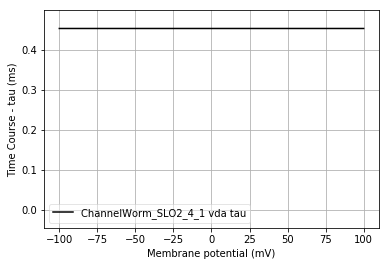

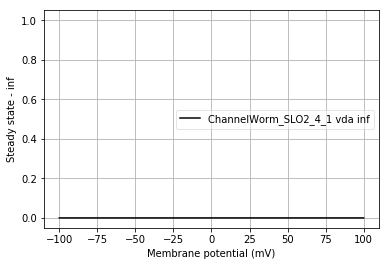

In [9]:
# Generate NeuroML2 file
model_params = {}
model_params['channel_name'] = 'SLO2'
model_params['channel_id'] = '4'
model_params['model_id'] = '1'
model_params['contributors'] = [{'name': 'Vahid Ghayoomi','email': 'vahidghayoomi@gmail.com'}]
model_params['references'] = [{'doi': '10.1038/77670',
                               'PMID': '10903569',
                               'citation': 'SLO-2, a K+ channel with an unusual Cl- dependence. '
                                           '(Yuan A; Dourado M; Butler A; Walton N; Wei A; Salkoff L. Nat. Neurosci., 3(8):771-9)'}]
model_params['file_name'] = cwd+'/slo-2-data/SLO-2.channel.nml'

nml2_file = myModelator.generate_channel_nml2(bio_params,best_candidate_params,model_params)
run_nml_out = myModelator.run_nml2(model_params['file_name'])